# **Expedia**

In [182]:
# Install lightgbm if not already installed
#%pip install --upgrade lightgbm
# Install optuna if not already installed
#%pip install optuna


## DS Method

In this part, we use the **Gradient Boosting Regressor** from scikit-learn, an ensemble learning algorithm from the field of machine learning. It builds a series of decision trees sequentially, where each new tree aims to correct the errors of the previous trees by minimizing the mean squared error (MSE) between the predicted continuous scores and the true target values. In our application, these continuous scores are later converted into a ranking order for each search page, and we measure the error as the sum of squared differences between the predicted and actual ranks. Essentially, this approach adapts a regression algorithm for a ranking task.
___

### imports

In [366]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, GroupKFold


### Load and Explore Data  
This cell loads the Expedia dataset from CSV and prints its basic information, missing value counts, numerical summary, and unique values for key categorical columns.


In [367]:
df = pd.read_csv('./Data/combined_expedia_results.csv')

# Basic info
print(f"Total rows in combined dataset: {len(df)}")
print("\nMissing values per column:\n", df.isnull().sum())

# Summary of numerical columns
print("\nNumerical column stats:\n", df.describe())

# Check unique values in categorical columns
categorical_cols = ['TTT', 'Neighborhood', 'Breakfast', 'Free Cancellation', 'search_group']
for col in categorical_cols:
    print(f"\nUnique values in {col}: {df[col].unique()}")


Total rows in combined dataset: 44518

Missing values per column:
 Snapshot Date         0
TTT                   0
LOS                   0
Hotel Name            0
Price                 0
Rating                0
Reviews               0
Neighborhood          0
Breakfast             0
Free Cancellation     0
Rooms Left            0
Check-in              0
Check-out             0
search_group          0
hotel_name_encoded    0
dtype: int64

Numerical column stats:
                 TTT           LOS         Price        Rating       Reviews  \
count  44518.000000  44518.000000  44518.000000  44518.000000  44518.000000   
mean      15.442989      2.983018    964.970731      2.715037   1856.039535   
std        8.617443      1.410342    528.421080      1.402482   1169.352833   
min        1.000000      1.000000    106.000000     -1.000000     -1.000000   
25%        8.000000      2.000000    528.000000      2.000000   1013.000000   
50%       15.000000      3.000000    916.000000      3.00000

### Clean Data  
This cell replaces placeholder -1 values in 'Rating', 'Neighborhood', and 'Rooms Left' with the median, mode, and 0 respectively, then shows the first few rows of the cleaned dataset.


In [368]:
# Handle missing or placeholder values (-1)
df['Rating'] = df['Rating'].replace(-1, df['Rating'].median())
df['Neighborhood'] = df['Neighborhood'].replace(-1, df['Neighborhood'].mode()[0]) 
df['Rooms Left'] = df['Rooms Left'].replace(-1, 0)  

print("Data cleaning and normalization complete!")
df.head()


Data cleaning and normalization complete!


,Snapshot Date,TTT,LOS,Hotel Name,Price,Rating,Reviews,Neighborhood,Breakfast,Free Cancellation,Rooms Left,Check-in,Check-out,search_group,hotel_name_encoded
0,2025-03-14,1,1,Courtyard New York Manhattan/ Midtown East,345.0,3.0,2243.0,14,0,0,5.0,2025-03-15,2025-03-16,0,56
1,2025-03-14,1,1,Millennium Premier New York Times Square,342.0,1.0,1004.0,16,1,0,0.0,2025-03-15,2025-03-16,1,234
2,2025-03-14,1,1,"PUBLIC, an Ian Schrager hotel",635.0,2.0,2809.0,14,0,0,0.0,2025-03-15,2025-03-16,2,261
3,2025-03-14,1,1,Residence Inn by Marriott New York Manhattan/M...,268.0,4.0,1001.0,14,1,0,5.0,2025-03-15,2025-03-16,3,283
4,2025-03-14,1,1,Hyatt Place New York City/Times Square,255.0,2.0,2435.0,14,1,0,0.0,2025-03-15,2025-03-16,4,197


### Split Data  
This cell splits the dataset into training (even TTT values) and test (odd TTT values) sets, shuffles the test set, and prints their sizes.


In [369]:
# Split train (even TTTs) and test (odd TTTs)
train_df = df[df['TTT'] % 2 == 0].copy()
test_df = df[df['TTT'] % 2 == 1].copy()

# Shuffle the test set to simulate a realistic ranking challenge
test_df_shuffled = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 22247, Test size: 22271


### Define Group Key and Prepare Modeling Data  
This cell creates a unique group key for each search by concatenating 'Snapshot Date', 'TTT', and 'LOS', assigns 'search_group' as the true ranking label, and builds training and test DataFrames including the group key for later use.

In [370]:
# Define group key (for grouping each search)
train_df['group_key'] = (
    train_df['Snapshot Date'].astype(str) + "_" +
    train_df['TTT'].astype(str) + "_" +
    train_df['LOS'].astype(str)
)
test_df_shuffled['group_key'] = (
    test_df_shuffled['Snapshot Date'].astype(str) + "_" +
    test_df_shuffled['TTT'].astype(str) + "_" +
    test_df_shuffled['LOS'].astype(str)
)

# Use search_group as the true ranking label (assumed to be 0-indexed)
y_train = train_df['search_group']
y_test = test_df_shuffled['search_group']

# Select features – now we add 'group_key' as an extra column so that our custom scorer can use it.
features = [
    'Price', 'Rating', 'Reviews', 'Neighborhood',
    'Breakfast', 'Free Cancellation', 'Rooms Left'
]
# Create a DataFrame for modeling that includes the group key
X_train = train_df[features + ['group_key']].copy()
X_test = test_df_shuffled[features + ['group_key']].copy()

### Custom Ranking Error Scorer  
This cell defines a custom scorer that, for each search group, computes the sum of squared differences between the predicted rank (derived by ranking predicted scores in descending order and then subtracting 1 so that the first hotel gets rank 0) and the true rank (from `search_group`, where 0 indicates the first hotel), and returns the negative mean error across groups so that lower error corresponds to a higher score.


In [ ]:
def ranking_error_scorer(estimator, X, y):
    """
    Computes the average (over groups) of the sum of squared differences between
    the predicted rank (obtained by ranking predicted scores within each group)
    and the true rank (search_group, where 0 means the first hotel).
    Returns the negative value so that lower error is better.
    """
    # Predict continuous scores using the estimator on the feature columns only.
    predicted_scores = estimator.predict(X[features])
    
    # Copy the DataFrame and add predictions and true ranks.
    df = X.copy()
    df['predicted_score'] = predicted_scores
    df['true_rank'] = y
    
    # Compute the predicted rank within each group.
    df['predicted_rank'] = df.groupby('group_key')['predicted_score'].rank(method='first', ascending=False) - 1
    
    # Compute error for each group: sum of squared differences.
    group_errors = df.groupby('group_key').apply(
        lambda g: np.sum((g['predicted_rank'] - g['true_rank'])**2)
    )
    
    # Return the negative mean error (because lower error is better)
    return -group_errors.mean()

# Create a scorer object.
custom_scorer = make_scorer(ranking_error_scorer, greater_is_better=True)


### Grid Search and Evaluation for Regression-Based Ranking  
This cell performs hyperparameter tuning on a GradientBoostingRegressor using GroupKFold, then uses the best model to convert continuous predictions into 0-indexed predicted ranks per group, calculates global and per-group error metrics (MSE), and visualizes predicted versus actual ranks for a sample group.

**At the end we just keep the param_grid with the best combination we found**

Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\alon1\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Global MSE (regression-based ranking): 695.2769071887208
Average sum of squared rank differences across groups: 68820.05333333333


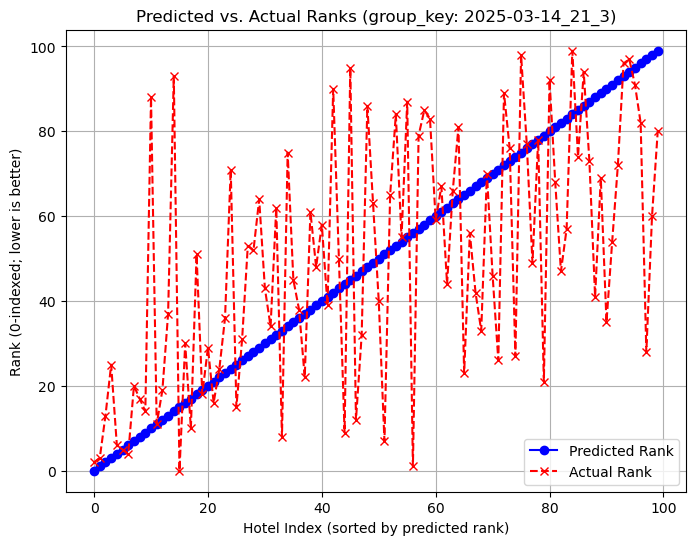

In [377]:
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.01],
    'max_depth': [10],
}

reg_model = GradientBoostingRegressor(random_state=42)

# Use GroupKFold to preserve groups in cross-validation.
group_kfold = GroupKFold(n_splits=3)

# We'll now run GridSearchCV. Notice we no longer pass a 'groups' parameter in the constructor,
# but we can pass it during fit if needed. However, since X_train already includes 'group_key',
# our custom scorer will work.
grid_search = GridSearchCV(
    estimator=reg_model,
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=group_kfold,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV.
# Prepare X_train without the group key
X_train_model = X_train[features]  # features does not include 'group_key'
# And similarly for X_test if needed
grid_search.fit(X_train_model, y_train, groups=train_df['group_key'].values)

# -------------------- Evaluate Best Estimator --------------------
best_regressor = grid_search.best_estimator_

# Predict continuous scores on the test set using best_regressor
test_df_shuffled['predicted_score_reg'] = best_regressor.predict(X_test[features])

# Convert scores to predicted ranks per group (assuming higher score is better)
test_df_shuffled['predicted_rank_reg'] = (
    test_df_shuffled.groupby("group_key")["predicted_score_reg"]
           .rank(method="first", ascending=True) - 1
).astype(int)

# Compute global MSE on ranks
global_mse_reg = mean_squared_error(test_df_shuffled["search_group"], test_df_shuffled["predicted_rank_reg"])
print("Global MSE (regression-based ranking):", global_mse_reg)

# Compute per-group error (sum of squared rank differences) and print summary
group_mses = test_df_shuffled.groupby("group_key").apply(
    lambda g: np.sum((g["search_group"] - g["predicted_rank_reg"])**2),
    include_groups=False
)
print("Average sum of squared rank differences across groups:", group_mses.mean())

# -------------------- Visualize Predictions vs. Actual Ranks for a Sample Group --------------------
sample_key = test_df_shuffled['group_key'].unique()[0]
sample_df = test_df_shuffled[test_df_shuffled['group_key'] == sample_key].copy()
sample_df = sample_df.sort_values(by='predicted_rank_reg', ascending=True)

plt.figure(figsize=(8, 6))
x_positions = np.arange(len(sample_df))
plt.plot(x_positions, sample_df['predicted_rank_reg'], marker='o', linestyle='-', color='blue', label='Predicted Rank')
plt.plot(x_positions, sample_df['search_group'], marker='x', linestyle='--', color='red', label='Actual Rank')
plt.title(f"Predicted vs. Actual Ranks (group_key: {sample_key})")
plt.xlabel("Hotel Index (sorted by predicted rank)")
plt.ylabel("Rank (0-indexed; lower is better)")
plt.legend()
plt.grid(True)
plt.show()

### Error Analysis

The mean error across test pages is approximately **56,519**, with a standard deviation of around **9,851**. This indicates that, on average, the sum of squared differences between the continuous predicted scores and the true ranks is fairly high, and there is notable variability across different search pages. These values suggest that the model's continuous outputs may differ significantly from the true ranking indices, so further tuning or feature improvements might be needed.

In addition, we can see in the attached graph that our prediction is not close to being good, but we have improved it from previous experiments.
The error values ​​are the smallest we have reached with this data and this method and we happy to see there aren't many  `Red X (Actual Rank)` in the top-left and bottom-right corners , becsuse these are the worst mistakes.


In [384]:
test_df_shuffled['true_rank'] = test_df_shuffled['search_group']

# Compute group errors as the sum of squared differences between predicted_score_reg and true_rank.
group_errors = test_df_shuffled.groupby("group_key", group_keys=False).apply(
    lambda g: np.sum((g["predicted_score_reg"] - g["true_rank"])**2)
)

mean_error = group_errors.mean()
std_error = group_errors.std()

print("Mean error (sum of squared differences) across Test pages:", mean_error)
print("Standard deviation of error across Test pages:", std_error)


Mean error (sum of squared differences) across Test pages: 56519.28444216251
Standard deviation of error across Test pages: 9850.704921201203


C:\Users\alon1\AppData\Local\Temp\ipykernel_11120\2204175104.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_errors = test_df_shuffled.groupby("group_key", group_keys=False).apply(


## Deep Learning Method

In this section, we implement a deep learning approach for ranking Expedia search results using a pairwise (Siamese) network. We first prepare the data by defining group keys and true ranking labels, then generate training pairs based on the relative order within each search page. The model is trained with a custom margin ranking loss to learn to score hotels such that lower scores indicate better ranking. Finally, we predict scores for the test set, convert these scores into predicted ranks, and evaluate the ranking performance using error metrics.

In [200]:
# Install tensorflow if not already installed
# %pip install tensorflow

### imports

In [436]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model






### Data Preparation  
This cell creates a unique group key for each search page by concatenating 'Snapshot Date', 'TTT', and 'LOS', sets 'search_group' as the 0-indexed true ranking label, and extracts the specified features into the training feature matrix.


In [ ]:

train_df['group_key'] = (
    train_df['Snapshot Date'].astype(str) + "_" +
    train_df['TTT'].astype(str) + "_" +
    train_df['LOS'].astype(str)
)
test_df['group_key'] = (
    test_df['Snapshot Date'].astype(str) + "_" +
    test_df['TTT'].astype(str) + "_" +
    test_df['LOS'].astype(str)
)

y_train = train_df['search_group'].values 
features = [
    'Price', 'Rating', 'Reviews', 'Neighborhood',
    'Breakfast', 'Free Cancellation', 'Rooms Left'
]
X_train = train_df[features].values

### Define the Base Network  
This cell builds a simple feed-forward neural network (the base network) with two hidden layers and dropout, which outputs a single continuous score for each hotel.


In [ ]:
def create_base_network(input_dim):
    inp = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inp)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    # Output a single score (linear activation)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)
    return model

input_dim = X_train.shape[1]
base_network = create_base_network(input_dim)

### Pairwise Model Setup  
This cell creates a pairwise model with two inputs using the shared base network,
and computes the score difference so that if an item is truly lower predicted score, the difference is positive.


In [ ]:
input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

score_a = base_network(input_a)
score_b = base_network(input_b)

score_diff = Subtract()([score_b, score_a])

### Custom Margin Ranking Loss and Pairwise Model  
This cell defines a custom margin ranking loss (assuming label=1 means that item a should be ranked higher than item b) and compiles the pairwise model using this loss with Adam optimizer.


In [440]:
# Define a custom margin ranking loss function.
# We assume label=1 means that input_a should be ranked higher than input_b.
def margin_ranking_loss(y_true, y_pred, margin=1.0):
    loss = tf.maximum(0.0, margin - y_true * y_pred)
    return tf.reduce_mean(loss)

# Create the pairwise model.
pair_model = Model(inputs=[input_a, input_b], outputs=score_diff)
pair_model.compile(optimizer='adam', 
                     loss=lambda y_true, y_pred: margin_ranking_loss(y_true, y_pred, margin=1.0))


### Generate Pairwise Training Data  
This cell generates pairwise training examples by grouping the data by `group_key`, sorting each group in ascending order of true rank (lower values mean better ranking), and then creating pairs (labeled 1) where the first item is ranked higher than the second.


In [441]:
# --------------------Generate Pairwise Training Data --------------------
def generate_pairs(X, y, group_keys):
    """
    Generate pairs of samples from the same group.
    For each group, for every pair (i, j) where y[i] < y[j] (i.e., item i is ranked better),
    create a pair (X[i], X[j]) with label 1.
    """
    pairs_a, pairs_b, labels = [], [], []
    df = pd.DataFrame(X, columns=features)
    df['rank'] = y
    df['group_key'] = group_keys
    # For each group, sort by true rank (ascending: lower rank means better)
    for g, group in df.groupby('group_key'):
        group = group.sort_values('rank')
        n = len(group)
        for i in range(n):
            for j in range(i+1, n):
                # Ensure that the features are numeric
                pairs_a.append(group.iloc[i][features].values.astype(np.float32))
                pairs_b.append(group.iloc[j][features].values.astype(np.float32))
                labels.append(1.0)  # Because item i is ranked better than item j
    return (np.array(pairs_a, dtype=np.float32),
            np.array(pairs_b, dtype=np.float32),
            np.array(labels, dtype=np.float32))

groups_train = train_df['group_key'].values
pairs_a, pairs_b, pair_labels = generate_pairs(X_train, y_train, groups_train)
print("Generated pairs:", pairs_a.shape, pairs_b.shape, pair_labels.shape)

Generated pairs: (1090227, 7) (1090227, 7) (1090227,)


### Train and Evaluate Pairwise Ranking Model  
This cell trains the pairwise ranking model on the generated pairs for 10 epochs, then uses the base network to predict continuous scores for the test set and converts these scores into 0-indexed predicted ranks by ranking them in ascending order (lower scores indicate better ranking).


In [442]:
# -------------------- Train the Pairwise Ranking Model --------------------
pair_model.fit([pairs_a, pairs_b], pair_labels, epochs=10, batch_size=128, validation_split=0.1)

# Use the base network to predict a score for each hotel in the test set.
X_test = test_df[features].values
predicted_scores = base_network.predict(X_test).flatten()

# Add the predicted scores to test_df
test_df['predicted_score_dl'] = predicted_scores

# Within each group, sort by predicted_score in descending order, and assign predicted ranks (0-indexed: 0 is first).
test_df['predicted_rank_dl'] = (
    test_df.groupby("group_key")['predicted_score_dl']
           .rank(method="first", ascending=True) - 1
).astype(int) 

Epoch 1/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 3.2734 - val_loss: 0.8380
Epoch 2/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8575 - val_loss: 0.8225
Epoch 3/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8457 - val_loss: 0.8218
Epoch 4/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8439 - val_loss: 0.8247
Epoch 5/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8391 - val_loss: 0.8493
Epoch 6/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8368 - val_loss: 0.8256
Epoch 7/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8349 - val_loss: 0.8153
Epoch 8/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8317 - val_loss: 0.8159
Epoch 9/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8270 - val_loss: 0.8332
Epoch 10/10
7666/7666 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.8261 - val_loss: 0.8139
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


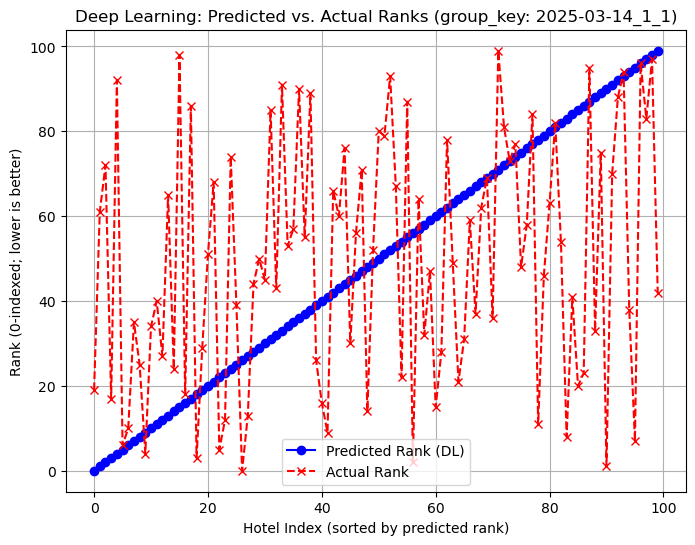

In [446]:
sample_key = test_df['group_key'].unique()[0]
sample_df = test_df[test_df['group_key'] == sample_key].copy()
sample_df = sample_df.sort_values(by='predicted_rank_dl', ascending=True)

plt.figure(figsize=(8, 6))
x_positions = np.arange(len(sample_df))
plt.plot(x_positions, sample_df['predicted_rank_dl'], marker='o', linestyle='-', color='blue', label='Predicted Rank (DL)')
plt.plot(x_positions, sample_df['search_group'], marker='x', linestyle='--', color='red', label='Actual Rank')
plt.title(f"Deep Learning: Predicted vs. Actual Ranks (group_key: {sample_key})")
plt.xlabel("Hotel Index (sorted by predicted rank)")
plt.ylabel("Rank (0-indexed; lower is better)")
plt.legend()
plt.grid(True)
plt.show()

### Results Analysis

The mean error (sum of squared differences) across test pages is approximately **101,448** with a standard deviation of about **20,543**, indicating that on average, the predicted ranking deviates significantly from the true ranking. This high error and variability suggest that the model may be struggling to capture the complex ranking relationships in the data. These results are 2 times worse then the DS approach we tried.


In [447]:
# Calculate the sum of squared differences for each group
group_errors = test_df.groupby("group_key", group_keys=False).apply(
    lambda g: np.sum((g["predicted_rank_dl"] - g["search_group"])**2)
)

# Compute the mean and standard deviation of errors across all groups
mean_error = group_errors.mean()
std_error = group_errors.std()

print("Mean error (sum of squared differences) across Test pages:", mean_error)
print("Standard deviation of error across Test pages:", std_error)

Mean error (sum of squared differences) across Test pages: 101448.50666666667
Standard deviation of error across Test pages: 20543.02467908163


C:\Users\alon1\AppData\Local\Temp\ipykernel_11120\2153200322.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_errors = test_df.groupby("group_key", group_keys=False).apply(


# **Booking**
___

## DS Method

___

### Booking Data Preparation  
This cell loads the Booking dataset, we decided to clean up all the rows with missing data to try to improve our ability to actually repeat the ranking.


In [416]:
# Load Booking data (adjust path as needed)
bdf = pd.read_csv('./TaskB - Booking/merged_booking_final.csv')

# Drop rows with missing values in key columns (if not already done)
columns_to_check = ['star_rating', 'rating_score', 'review_amount', 'location_score']
bdf = bdf.dropna(subset=columns_to_check).copy()

# Convert group_index to 0-indexed true rank (0 = best)
bdf['true_rank'] = bdf['group_index'] - 1

# Define group key: here we combine snapshot, checkin, and checkout.
bdf['group_key'] = bdf['snapshot'] + "_" + bdf['checkin'] + "_" + bdf['checkout']

# Define the features to use (all numeric features with meaning)
features_booking = [
    'star_rating', 'rating_score', 'location_score', 'review_amount', 
    'price', 'breakfast_included', 'free_cancellation', 'no_prepayment_needed',
    'centrally_located', 'sustainability_certification', 'bed_score', 'distance_score', 
    'hotel_name_encoded'
]

### Data Splitting  
This cell splits the Booking dataset into training and test sets based on the 'ttt' column.


In [417]:
# Split train (even TTTs) and test (odd TTTs)
train_bdf = bdf[bdf['ttt'] % 2 == 0].copy()
test_bdf = bdf[bdf['ttt'] % 2 == 1].copy()

test_bdf_shuffled = test_bdf.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Train size: {len(train_bdf)}, Test size: {len(test_bdf_shuffled)}")

Train size: 13381, Test size: 13151


### Prepare Features and Labels  
This cell extracts the feature matrix and 0-indexed true ranking labels for both training and test sets from the Booking data.


In [418]:
X_train_booking = train_bdf[features_booking].copy()
y_train_booking = train_bdf['true_rank'].values

X_test_booking = test_bdf_shuffled[features_booking].copy()
y_test_booking = test_bdf_shuffled['true_rank'].values

### Train the Regression Model  
This cell initializes a GradientBoostingRegressor with specified hyperparameters and fits it on the Booking training data to predict the 0-indexed true ranks.

In [419]:
reg_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=10,
    random_state=42
)
reg_model.fit(X_train_booking, y_train_booking)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=500,
                          random_state=42)

### Evaluate Regression-Based Ranking on Booking Data  
This cell uses the trained regression model to predict continuous scores for the test set, converts them into 0-indexed ranks (with lower scores indicating higher in the page), and computes both the global MSE and the average sum of squared rank differences across groups.


In [421]:
test_bdf_shuffled['predicted_score'] = reg_model.predict(X_test_booking)

test_bdf_shuffled['predicted_rank'] = (test_bdf_shuffled.groupby("group_key")["predicted_score"].rank(method="first", ascending=True) - 1).astype(int)

global_mse = mean_squared_error(test_bdf_shuffled['true_rank'], test_bdf_shuffled['predicted_rank'])
print("Global MSE (regression-based ranking on Booking data):", global_mse)

# Compute the error per group: sum of squared differences between predicted and true rank, for each group.
group_errors = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(
    lambda g: np.sum((g["predicted_rank"] - g["true_rank"])**2)
)
print("Average sum of squared rank differences across groups:", group_errors.mean())

Global MSE (regression-based ranking on Booking data): 743.0101893392138
Average sum of squared rank differences across groups: 43428.12


C:\Users\alon1\AppData\Local\Temp\ipykernel_11120\1414888463.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_errors = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(


C:\Users\alon1\AppData\Local\Temp\ipykernel_11120\2762926903.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_errors_before = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(


Before re-indexing:
Mean error (sum of squared differences) across groups: 43428.12
Standard deviation of error across groups: 8338.174809851547


C:\Users\alon1\AppData\Local\Temp\ipykernel_11120\2762926903.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(reindex_local_true_rank)


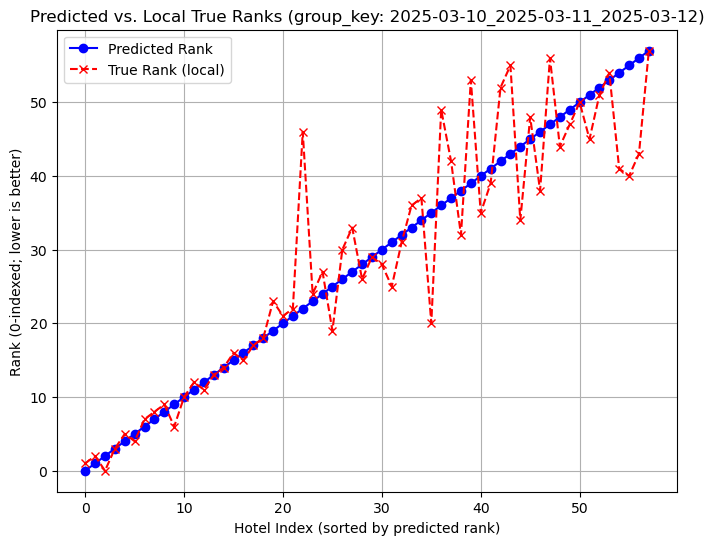

After re-indexing:
Mean error (sum of squared differences) across groups: 3982.266666666667
Standard deviation of error across groups: 3809.5098156737026


C:\Users\alon1\AppData\Local\Temp\ipykernel_11120\2762926903.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_errors = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(


In [455]:
group_errors_before = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(
    lambda g: np.sum((g["predicted_rank"] - g["true_rank"])**2)
)

mean_error_before = group_errors_before.mean()
std_error_before = group_errors_before.std()

print("Before re-indexing:")
print("Mean error (sum of squared differences) across groups:", mean_error_before)
print("Standard deviation of error across groups:", std_error_before)



def reindex_local_true_rank(df):
    """
    Sort by the original 'true_rank', then reassign local ranks 0..(N-1) 
    for the N items that remain in this group.
    """
    # Sort the group by the old true_rank
    df = df.sort_values(by='true_rank').reset_index(drop=True)
    # Assign new ranks 0..(N-1)
    df['true_rank_local'] = np.arange(len(df))
    return df

# 2) After you have your test set (e.g., test_bdf_shuffled),
#    apply the local rank re-indexing:
test_bdf_shuffled = (
    test_bdf_shuffled
    .groupby('group_key', group_keys=False)
    .apply(reindex_local_true_rank)
    .copy()
)

# 3) Now, when you plot, use 'true_rank_local' instead of 'true_rank'.
sample_key = test_bdf_shuffled['group_key'].unique()[0]
sample_df = test_bdf_shuffled[test_bdf_shuffled['group_key'] == sample_key].copy()

# Sort by predicted_rank if you want to see the predicted ordering
sample_df = sample_df.sort_values(by='predicted_rank', ascending=True)

# 4) Plot
plt.figure(figsize=(8, 6))
x_positions = np.arange(len(sample_df))
plt.plot(
    x_positions, 
    sample_df['predicted_rank'], 
    marker='o', linestyle='-', color='blue', label='Predicted Rank'
)
plt.plot(
    x_positions, 
    sample_df['true_rank_local'],  # use the local re-indexed rank
    marker='x', linestyle='--', color='red', label='True Rank (local)'
)
plt.title(f"Predicted vs. Local True Ranks (group_key: {sample_key})")
plt.xlabel("Hotel Index (sorted by predicted rank)")
plt.ylabel("Rank (0-indexed; lower is better)")
plt.legend()
plt.grid(True)
plt.show()


group_errors = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(
    lambda g: np.sum((g["predicted_rank"] - g["true_rank_local"])**2)
)

mean_error = group_errors.mean()
std_error = group_errors.std()
print("After re-indexing:")
print("Mean error (sum of squared differences) across groups:", mean_error)
print("Standard deviation of error across groups:", std_error)

### Analysis

- **Global MSE (regression-based ranking):** 743.01  
  This represents the overall mean squared error between predicted and true ranks across all hotels.

- **Average Sum of Squared Rank Differences (Absolute Scale):** 43,428.12  
  This metric, computed per search group, reflects the cumulative squared errors on the original ranking scale.

- **Local Re-indexed(because we removed a lot of rows) Error:**  
  After re-indexing each group’s true ranks to a 0–(N–1) scale, the mean error is 3,982.27 with a standard deviation of 3,809.51, indicating significant variability across groups.


## Deep Learning Method

### Prepare Training and Testing Data  
This cell extracts the feature matrices, true rank labels, and group keys from the Booking data for use in training and pair generation.


In [448]:
# X and y for training
X_train_booking = train_bdf[features_booking].values
y_train_booking = train_bdf['true_rank'].values

# X and y for testing
X_test_booking = test_bdf_shuffled[features_booking].values
y_test_booking = test_bdf_shuffled['true_rank'].values

# Group keys for training (used later for pair generation)
groups_train = train_bdf['group_key'].values


### Define the Base Network  
This cell defines a simple feed-forward neural network with two hidden layers and dropout, which outputs a single continuous score for each hotel.


In [430]:
def create_base_network(input_dim):
    inp = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inp)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    # Output a single score (linear activation)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)
    return model

input_dim = X_train_booking.shape[1]
base_network = create_base_network(input_dim)

### Pairwise Model Setup  
This cell creates two inputs that are processed by the shared base network, then computes the score difference so that a lower predicted score leads to a positive difference.


In [431]:
# Two inputs for the pairwise model
input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

score_a = base_network(input_a)
score_b = base_network(input_b)

# Score difference: we want score_a (for the better item) to be higher than score_b.
score_diff = Subtract()([score_b, score_a])


### Custom Margin Ranking Loss and Model Compilation  
This cell defines a custom margin ranking loss function and compiles the pairwise model using the Adam optimizer, the loss function penalizes pairs that do not have a positive `score_diff`


In [432]:
def margin_ranking_loss(y_true, y_pred, margin=1.0):
    loss = tf.maximum(0.0, margin - y_true * y_pred)
    return tf.reduce_mean(loss)

pair_model = Model(inputs=[input_a, input_b], outputs=score_diff)
pair_model.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: margin_ranking_loss(y_true, y_pred, margin=1.0)
)


### Generate Pairwise Training Data  
This cell groups the data by `group_key`, sorts each group in ascending order of true rank, and generates pairs (with label 1) for every combination where the first item is ranked higher than the second.


In [428]:
def generate_pairs(X, y, group_keys):
    """
    Generate pairs of samples from the same group.
    For each group, for every pair (i, j) where y[i] < y[j] (i.e., item i is ranked better),
    create a pair (X[i], X[j]) with label 1.
    """
    pairs_a, pairs_b, labels = [], [], []
    df = pd.DataFrame(X, columns=features_booking).copy()
    df['rank'] = y
    df['group_key'] = group_keys
    # For each group, sort by true rank (ascending: lower rank is better)
    for g, group in df.groupby('group_key'):
        group = group.sort_values('rank')
        n = len(group)
        for i in range(n):
            for j in range(i+1, n):
                pairs_a.append(group.iloc[i][features_booking].values.astype(np.float32))
                pairs_b.append(group.iloc[j][features_booking].values.astype(np.float32))
                labels.append(1.0)  # Because item i should be ranked higher than item j
    return (np.array(pairs_a, dtype=np.float32),
            np.array(pairs_b, dtype=np.float32),
            np.array(labels, dtype=np.float32))

pairs_a, pairs_b, pair_labels = generate_pairs(X_train_booking, y_train_booking, groups_train)
print("Generated pairs:", pairs_a.shape, pairs_b.shape, pair_labels.shape)


Generated pairs: (385120, 13) (385120, 13) (385120,)


### Train Pairwise Model and Predict Ranks  
This cell trains the pairwise ranking model on the generated pairs, then uses the base network to predict continuous scores on the test set. The predicted scores are converted into 0-indexed ranks per group by ranking in ascending order (lower score means higher in the page).


In [433]:
pair_model.fit(
    [pairs_a, pairs_b], pair_labels,
    epochs=10, 
    batch_size=128, 
    validation_split=0.1
)

# Predict continuous scores on the test set using the base network.
predicted_scores_test = base_network.predict(X_test_booking).flatten()

# Add predicted scores to the test DataFrame.
test_bdf_shuffled['predicted_score_dl'] = predicted_scores_test

# For each group, sort by predicted_score in ascending order (lower score means better rank)
# and assign predicted ranks (0-indexed: 0 is best).
test_bdf_shuffled['predicted_rank_dl'] = (
    test_bdf_shuffled.groupby("group_key")['predicted_score_dl']
                     .rank(method="first", ascending=True) - 1
).astype(int)


Epoch 1/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 10.4582 - val_loss: 0.8749
Epoch 2/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8887 - val_loss: 0.8026
Epoch 3/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8314 - val_loss: 0.7554
Epoch 4/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7904 - val_loss: 0.7645
Epoch 5/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7781 - val_loss: 0.7429
Epoch 6/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7639 - val_loss: 0.7069
Epoch 7/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7553 - val_loss: 0.7051
Epoch 8/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7429 - val_loss: 0.6623
Epoch 9/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7416 - val_loss: 0.6868
Epoch 10/10
2708/2708 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7280 - val_loss: 0.6700
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


In [434]:
global_mse_dl = mean_squared_error(test_bdf_shuffled['true_rank'], test_bdf_shuffled['predicted_rank_dl'])
print("Global MSE (deep learning ranking on Booking data):", global_mse_dl)

group_errors_dl = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(
    lambda g: np.sum((g["predicted_rank_dl"] - g["true_rank"])**2)
)

mean_error = group_errors_dl.mean()
std_error = group_errors_dl.std()

print("Average sum of squared rank differences across groups:", mean_error)
print("Standard deviation of error across groups:", std_error)

Global MSE (deep learning ranking on Booking data): 1043.5683218006236
Average sum of squared rank differences across groups: 60995.40888888889
Standard deviation of error across groups: 9973.152076499788


C:\Users\alon1\AppData\Local\Temp\ipykernel_11120\1617365483.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_errors_dl = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(


### Evaluate Local Ranking Error  
This cell reindexes the true ranks locally for each group and then computes the mean and standard deviation of the sum of squared differences between the predicted ranks and the locally reindexed true ranks.


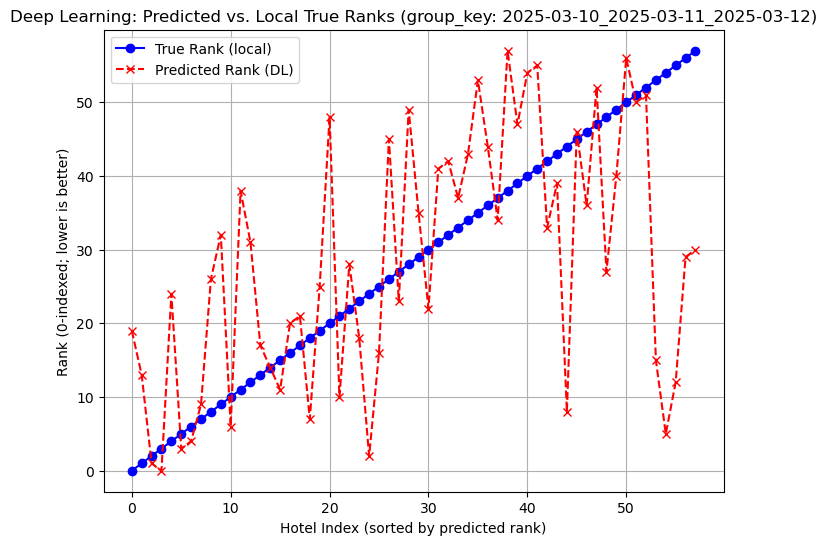

Mean error (sum of squared differences, local) across Test pages: 13884.693333333333
Standard deviation of error (local) across Test pages: 5345.419409176421


C:\Users\alon1\AppData\Local\Temp\ipykernel_11120\2523027393.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_errors_local = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(


In [454]:
def reindex_local_true_rank(df):
    """
    Sort by the original 'true_rank' and then reassign local ranks from 0 to (N-1)
    for the N items remaining in the group.
    """
    # Sort the group by the old true_rank
    df = df.sort_values(by='true_rank').reset_index(drop=True)
    # Assign new local ranks 0..(N-1)
    df['true_rank_local'] = np.arange(len(df))
    return df

# For a sample group, reindex the true ranks locally and plot the comparison
sample_key = test_bdf_shuffled['group_key'].unique()[0]
sample_df = test_bdf_shuffled[test_bdf_shuffled['group_key'] == sample_key].copy()
sample_df = sample_df.sort_values(by='predicted_rank_dl', ascending=True)
sample_df = reindex_local_true_rank(sample_df)

plt.figure(figsize=(8, 6))
x_positions = np.arange(len(sample_df))
plt.plot(x_positions, sample_df['true_rank_local'], marker='o', linestyle='-', color='blue', label='True Rank (local)')
plt.plot(x_positions, sample_df['predicted_rank_dl'], marker='x', linestyle='--', color='red', label='Predicted Rank (DL)')
plt.title(f"Deep Learning: Predicted vs. Local True Ranks (group_key: {sample_key})")
plt.xlabel("Hotel Index (sorted by predicted rank)")
plt.ylabel("Rank (0-indexed; lower is better)")
plt.legend()
plt.grid(True)
plt.show()

# Now compute the error using the locally reindexed true ranks
group_errors_local = test_bdf_shuffled.groupby("group_key", group_keys=False).apply(
    lambda g: np.sum((g["predicted_rank_dl"] - g["true_rank_local"])**2)
)

mean_error_local = group_errors_local.mean()
std_error_local = group_errors_local.std()

print("Mean error (sum of squared differences, local) across Test pages:", mean_error_local)
print("Standard deviation of error (local) across Test pages:", std_error_local)


### Analysis

After re-indexing each search group to range from 0 to N–1, the average sum of squared rank differences across groups drops to 13,884 with a standard deviation of about 5,345. This indicates that, on a relative scale, the model’s ranking errors within each group are considerably lower and more consistent than on the absolute scale. The results are not conpareable to the DS method.








# **Summary**
- **DS Approach:**

In the data science approach, we treat the ranking problem as a regression task. We train a regressor (in this case, a Gradient Boosting Regressor) to predict a continuous score that represents the rank for each hotel.

We assume that there is a continuous underlying value (or "score") that determines the hotel's rank. The regressor learns to map the input features (like Price, Rating, etc.) to this continuous score, which ideally correlates with the hotel's true rank.

Ranking from Scores:
Once we have these predicted scores, we convert them into ranks by sorting them within each group. If lower scores indicate a better hotel, we rank in ascending order (i.e., the lowest score gets rank 0). This way, even though the regressor is not explicitly trained to order items, it indirectly learns the ranking by minimizing the difference between its predicted score and the true rank.

Error Calculation:
We then evaluate the model by comparing the predicted ranks with the true ranks (using metrics like mean squared error across groups). This gives us a measure of how well the regressor's continuous outputs capture the correct ordering.

In summary, the regression approach solves the ranking problem by learning a continuous scoring function from the features, which is then transformed into a rank order through sorting.

- **Deep Learning Approach:**

In the deep learning method, we use a pairwise ranking approach. Instead of training a regressor to predict a continuous score for each hotel directly, we train a neural network to compare pairs of hotels. The network, which we implement in a Siamese architecture, processes two hotels through a shared base network and then computes the difference between their scores. We then use a custom margin ranking loss that penalizes cases where the higher-ranked hotel (the one that should be better) does not have a sufficiently lower score than the other. Essentially, the network is learning to decide, for any given pair, which hotel should be ranked higher. After training, the base network is used to predict scores for individual hotels on a search page, and then those scores are sorted to form a final ranking. This approach directly trains the model on the relative ordering within each group rather than on absolute scores.
